# Lesson 4 - Hybrid Search

### Import the Needed Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datasets import load_dataset
from pinecone_text.sparse import BM25Encoder
from pinecone import Pinecone, ServerlessSpec
from DLAIUtils import Utils

from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import torch
import os

In [3]:
utils = Utils()
PINECONE_API_KEY = utils.get_pinecone_api_key()

In [ ]:
utils.get_pinecone_api_key()

### Setup Pinecone

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

utils = Utils()
INDEX_NAME = utils.create_dlai_index_name('dl-ai')

pinecone = Pinecone(api_key=PINECONE_API_KEY)

if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)
pinecone.create_index(
  INDEX_NAME,
  dimension=512,
  metric="dotproduct",
  spec=ServerlessSpec(cloud='aws', region='us-west-2')
)
index = pinecone.Index(INDEX_NAME)

cpu


### Load the Dataset

In [5]:
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

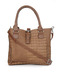

In [6]:
images = fashion['image']
metadata = fashion.remove_columns('image')
images[800]

In [10]:
type(fashion)

datasets.arrow_dataset.Dataset

In [8]:
fashion.to_pandas().head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [7]:
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


### Create the Sparse Vector Using BM25

In [11]:
bm25 = BM25Encoder()
bm25.fit(metadata['productDisplayName'])
metadata['productDisplayName'][0]

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  0%|          | 0/44072 [00:00<?, ?it/s]

'Turtle Check Men Navy Blue Shirt'

In [16]:
bm25.encode_queries(metadata['productDisplayName'][0])
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

### Create the Dense Vector Using CLIP

In [17]:
model = SentenceTransformer('sentence-transformers/clip-ViT-B-32', 
    device=device)
model
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

(1, 512)

In [22]:
dense_vec

array([[ 3.47599238e-01,  1.86053246e-01, -3.43704075e-02,
        -8.76949653e-02,  2.12450728e-01, -4.63767529e-01,
        -2.62030393e-01, -2.67075807e-01,  2.11454466e-01,
        -1.45174474e-01, -2.21526474e-01,  7.72616565e-01,
         4.07888144e-01,  1.98981389e-01, -2.40782410e-01,
         1.00482211e-01,  3.12819719e-01,  2.33211994e-01,
         2.81544954e-01,  3.93812060e-01,  1.04463331e-01,
         2.52281763e-02,  2.92443931e-01, -2.01948255e-01,
         1.52713493e-01, -2.10447222e-01,  6.16779029e-02,
        -1.53535306e-01,  6.78100884e-02, -5.04500747e-01,
         2.05991790e-02,  2.61264890e-01,  2.34380007e-01,
        -9.56329107e-02, -3.77705395e-02, -2.17030048e-02,
        -1.11793987e-01,  2.48099625e-01, -1.26485333e-01,
        -1.26278728e-01, -1.43248171e-01, -3.04490834e-01,
        -3.61693799e-01, -1.24217361e-01, -2.30935916e-01,
         1.33257091e-01, -1.69667602e-01, -1.21024296e-01,
         9.53745544e-02,  1.76042289e-01, -2.91511774e-0

In [18]:
dense_vec

array([[ 3.47599238e-01,  1.86053246e-01, -3.43704075e-02,
        -8.76949653e-02,  2.12450728e-01, -4.63767529e-01,
        -2.62030393e-01, -2.67075807e-01,  2.11454466e-01,
        -1.45174474e-01, -2.21526474e-01,  7.72616565e-01,
         4.07888144e-01,  1.98981389e-01, -2.40782410e-01,
         1.00482211e-01,  3.12819719e-01,  2.33211994e-01,
         2.81544954e-01,  3.93812060e-01,  1.04463331e-01,
         2.52281763e-02,  2.92443931e-01, -2.01948255e-01,
         1.52713493e-01, -2.10447222e-01,  6.16779029e-02,
        -1.53535306e-01,  6.78100884e-02, -5.04500747e-01,
         2.05991790e-02,  2.61264890e-01,  2.34380007e-01,
        -9.56329107e-02, -3.77705395e-02, -2.17030048e-02,
        -1.11793987e-01,  2.48099625e-01, -1.26485333e-01,
        -1.26278728e-01, -1.43248171e-01, -3.04490834e-01,
        -3.61693799e-01, -1.24217361e-01, -2.30935916e-01,
         1.33257091e-01, -1.69667602e-01, -1.21024296e-01,
         9.53745544e-02,  1.76042289e-01, -2.91511774e-0

In [14]:
len(fashion)

44072

In [23]:
meta_batch = metadata.iloc[:10]
meta_batch

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


In [24]:
meta_batch.to_dict(orient="records")

[{'id': 15970,
  'gender': 'Men',
  'masterCategory': 'Apparel',
  'subCategory': 'Topwear',
  'articleType': 'Shirts',
  'baseColour': 'Navy Blue',
  'season': 'Fall',
  'year': 2011.0,
  'usage': 'Casual',
  'productDisplayName': 'Turtle Check Men Navy Blue Shirt'},
 {'id': 39386,
  'gender': 'Men',
  'masterCategory': 'Apparel',
  'subCategory': 'Bottomwear',
  'articleType': 'Jeans',
  'baseColour': 'Blue',
  'season': 'Summer',
  'year': 2012.0,
  'usage': 'Casual',
  'productDisplayName': 'Peter England Men Party Blue Jeans'},
 {'id': 59263,
  'gender': 'Women',
  'masterCategory': 'Accessories',
  'subCategory': 'Watches',
  'articleType': 'Watches',
  'baseColour': 'Silver',
  'season': 'Winter',
  'year': 2016.0,
  'usage': 'Casual',
  'productDisplayName': 'Titan Women Silver Watch'},
 {'id': 21379,
  'gender': 'Men',
  'masterCategory': 'Apparel',
  'subCategory': 'Bottomwear',
  'articleType': 'Track Pants',
  'baseColour': 'Black',
  'season': 'Fall',
  'year': 2011.0,
  '

In [26]:
meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]

In [27]:
meta_batch

['Men Apparel Topwear Shirts Navy Blue Fall Casual Turtle Check Men Navy Blue Shirt',
 'Men Apparel Bottomwear Jeans Blue Summer Casual Peter England Men Party Blue Jeans',
 'Women Accessories Watches Watches Silver Winter Casual Titan Women Silver Watch',
 'Men Apparel Bottomwear Track Pants Black Fall Casual Manchester United Men Solid Black Track Pants',
 'Men Apparel Topwear Tshirts Grey Summer Casual Puma Men Grey T-shirt',
 'Men Apparel Topwear Tshirts Grey Summer Casual Inkfruit Mens Chain Reaction T-shirt',
 'Men Apparel Topwear Shirts Green Summer Ethnic Fabindia Men Striped Green Shirt',
 'Women Apparel Topwear Shirts Purple Summer Casual Jealous 21 Women Purple Shirt',
 'Men Accessories Socks Socks Navy Blue Summer Casual Puma Men Pack of 3 Socks',
 'Men Accessories Watches Watches Black Winter Casual Skagen Men Black Watch']

In [28]:
sparse_embeds = bm25.encode_documents([text for text in meta_batch])

In [29]:
sparse_embeds

[{'indices': [632192512,
   1540502846,
   2795873812,
   3828986392,
   931643408,
   3905155331,
   453950983,
   4127429595,
   23789636,
   1830646559],
  'values': [0.4434060234867922,
   0.28485657157689115,
   0.28485657157689115,
   0.4434060234867922,
   0.4434060234867922,
   0.4434060234867922,
   0.28485657157689115,
   0.28485657157689115,
   0.28485657157689115,
   0.28485657157689115]},
 {'indices': [632192512,
   1540502846,
   2285686478,
   120765854,
   3905155331,
   3514932624,
   4127429595,
   2783072804,
   353257611,
   201915537],
  'values': [0.4594909326499504,
   0.2982721376904044,
   0.2982721376904044,
   0.4594909326499504,
   0.4594909326499504,
   0.2982721376904044,
   0.2982721376904044,
   0.2982721376904044,
   0.2982721376904044,
   0.2982721376904044]},
 {'indices': [720498841,
   908597267,
   926942048,
   2422913126,
   2043717068,
   4127429595,
   1131532073],
  'values': [0.4954355786719864,
   0.32928837851601395,
   0.5956101406580641,
 

In [38]:
img_batch = images[i:i_end]
img_batch

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile imag

In [37]:
dense_embeds = model.encode(img_batch).tolist()

In [39]:
dense_embeds

[[0.057046957314014435,
  0.15600499510765076,
  -0.30840644240379333,
  0.2544470429420471,
  -0.06971409916877747,
  0.1616303026676178,
  -0.17396028339862823,
  -0.6608730554580688,
  0.6814531087875366,
  0.2940356731414795,
  0.2948041260242462,
  0.5626001954078674,
  0.6064233779907227,
  0.07351978868246078,
  -0.27152329683303833,
  0.2678612470626831,
  0.4498421549797058,
  0.2032168209552765,
  0.4176638126373291,
  0.09653769433498383,
  0.022325828671455383,
  -0.26122719049453735,
  0.5459328889846802,
  -0.6118751168251038,
  -0.21398581564426422,
  0.30850785970687866,
  -0.020704321563243866,
  -0.2410990595817566,
  -0.25908470153808594,
  -0.20902417600154877,
  0.44795650243759155,
  -0.29376497864723206,
  -0.3911202847957611,
  -0.4234617054462433,
  0.20303824543952942,
  -0.30029377341270447,
  0.1629742830991745,
  0.2480677366256714,
  -0.0011900067329406738,
  1.4264079332351685,
  -0.40113458037376404,
  -0.2857648432254791,
  -0.4633185565471649,
  -0.120

### Create Embeddings Using Sparse and Dense

<p style="background-color:#fff1d7; padding:15px; "> <b>(Note: <code>fashion_data_num = 1000</code>):</b> In this lab, we've initially set <code>fashion_data_num</code> to 1000 for speedier results, allowing you to observe the outcomes faster. Once you've done an initial run, consider increasing this value. You'll likely notice better and more relevant results.</p>

In [19]:
batch_size = 100
fashion_data_num = 1000

for i in tqdm(range(0, min(fashion_data_num,len(fashion)), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

  0%|          | 0/10 [00:00<?, ?it/s]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

### Run Your Query

In [33]:
query = "dark blue french connection jeans for men"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]

In [34]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


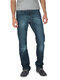
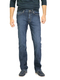
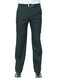
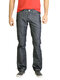
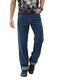
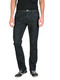
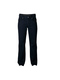
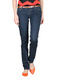
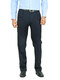
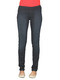

In [35]:
display_result(imgs)


### Scaling the Hybrid Search

In [40]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

### 1. More Dense


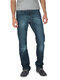
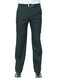
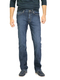
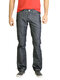
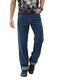
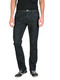
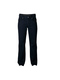
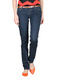
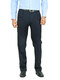
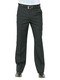

In [41]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)



In [42]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Peter England Men Party Blue Jeans
John Miller Men Reglur Black Trousers
Lee Men Blue Chicago Fit Jeans
Locomotive Men Washed Blue Jeans
Lee Men Blue Chicago Fit Jeans
Peter England Men Black Jeans
Gini and Jony Boys Solid Black Jeans
Tokyo Talkies Women Navy Slim Fit Jeans
Arrow Men Navy Blue Solid Trousers
John Miller Men Solid Type Black Trousers


### 2. More Sparse


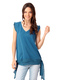
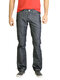
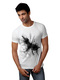
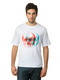
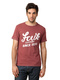
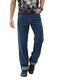
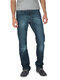
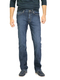
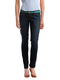
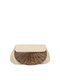

In [43]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [44]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Women Blue Top
Locomotive Men Washed Blue Jeans
French Connection Men White T-shirt
French Connection Men White T-shirt
French Connection Men Maroon T-shirt
Lee Men Blue Chicago Fit Jeans
Peter England Men Party Blue Jeans
Lee Men Blue Chicago Fit Jeans
Denizen Women Blue Jeans
French Connection Women Beige Clutch


### More Dense or More Sparse?


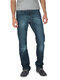
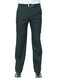
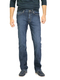
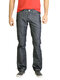
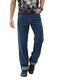
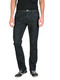
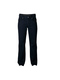
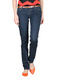
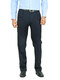
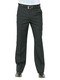

In [45]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)


In [46]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Peter England Men Party Blue Jeans
John Miller Men Reglur Black Trousers
Lee Men Blue Chicago Fit Jeans
Locomotive Men Washed Blue Jeans
Lee Men Blue Chicago Fit Jeans
Peter England Men Black Jeans
Gini and Jony Boys Solid Black Jeans
Tokyo Talkies Women Navy Slim Fit Jeans
Arrow Men Navy Blue Solid Trousers
John Miller Men Solid Type Black Trousers
